In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from numpy import pi

#MATLAB init
import matlab.engine
eng = matlab.engine.start_matlab()



PosVel_read = open('Velocidad.txt','r')

PosVel_split = [line.split(',') for line in PosVel_read.readlines()]


#Feature extraction for both velocity and position
iteration = 0 #Iteration
rcount = 1    #Row number

while rcount <len(PosVel_split):
    
    if iteration==0:
        if (rcount-(6*iteration))==1:
            Vel_array = np.array([PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.array([PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]])
            iteration += 1
            
    else:
        if (rcount-(6*iteration))==1:
            Vel_array = np.vstack([Vel_array,[PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.vstack([Pos_array,[PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]]])
            iteration += 1
            
            
    rcount+=3
    
#Conversion to type float64
    
Pos_array = Pos_array.astype('float64')
Vel_array = Vel_array.astype('float64')


#Data cleaning - Data that equals to zero must be removed, in this case we have 3 bad data points

iteration = 0
a = []

while iteration<len(Pos_array):

    if (Pos_array[iteration][0]==0.0) or (Pos_array[iteration][1]==0.0):  #We detect North or East equal to zero     
        a.append(iteration)
        #print(iteration)

    iteration +=1
    
Pos_array = np.delete(Pos_array,a,0)
Vel_array = np.delete(Vel_array,a,0)



#Data Frame Creation

Pos_DataFrame = pd.DataFrame(Pos_array,[np.arange(0,len(Pos_array))],['North','East','Height','N_dev','E_dev'
                                                            ,'Hei_dev'])

Vel_DataFrame = pd.DataFrame(Vel_array,[np.arange(0,len(Pos_array))],['Latency','Hspeed','TrackDir','Vspeed'])


#Add total speed. We set if it is 2D or 3D mode

Mode_3D = False    

Vel_DataFrame['Total_Speed'] = ((Vel_DataFrame['Hspeed']**2)+(Mode_3D*Vel_DataFrame['Vspeed']**2))**(1/2)


#Vector

Vector = Pos_DataFrame[['North','East']]
Vector['Total_Speed'] = Vel_DataFrame['Total_Speed']

Vector_array = Vector.to_numpy()


#Vector_errors

Vector_errors = Pos_DataFrame[['N_dev','E_dev']]
Vector_errors['Vel_dev'] = 0

Vector_err_array = Vector_errors.to_numpy()



# KALMAN FILTER STARTS HERE
#We construct the different matrices and the initial state

measurements = len(Pos_array)
dt = Vel_array.mean(axis=0)[0]
repeat = 0
flag_repeat = False

alpha = Vel_array[0][2]*(pi/180)
M = matlab.double([[Vector_array[0][0]],[Vector_array[0][1]],[Vector_array[0][2]*(np.sin((pi/2)-alpha))],[Vector_array[0][2]*(np.cos((pi/2)-alpha))],[0],[0]])  #Initial state

A = matlab.double([[1.0,0.0,dt,0.0,0.5*(dt**2),0.0],                    #Transformation Matrix
                   [0.0,1.0,0.0,dt,0.0,0.5*(dt**2)],
                   [0.0,0.0,1.0,0.0,dt,0.0],
                   [0.0,0.0,0.0,1.0,0.0,dt],
                   [0.0,0.0,0.0,0.0,1,0.0],
                   [0.0,0.0,0.0,0.0,0.0,1]])


#P = matlab.double((np.diag([Vector_err_array[0][0],Vector_err_array[0][1],1,1,1,1]))**2)         #Initial state covariance

P = matlab.double([[Vector_err_array[0][0],0.0,0.0,0.0,0.0,0.0],                    #Transformation Matrix
                   [0.0,Vector_err_array[0][1],0.0,0.0,0.0,0.0],
                   [0.0,0.0,1.0,0.0,0.0,0.0],
                   [0.0,0.0,0.0,1.0,0.0,0.0],
                   [0.0,0.0,0.0,0.0,1.0,0.0],
                   [0.0,0.0,0.0,0.0,0.0,1.0]])

#factor = 8.8
#G = np.array([[0.5*(dt**2)],[0.5*(dt**2)],[1*dt],[1*dt],[1],[1]])
#Q = (G@G.T)*((factor)**2)

Q = matlab.double([[2.14105448e-02,2.14105448e-02,2.34815695e-01,2.34815695e-01,1.28764614e+00,1.28764614e+00],
                   [2.14105448e-02,2.14105448e-02,2.34815695e-01,2.34815695e-01,1.28764614e+00,1.28764614e+00],
                   [2.34815695e-01,2.34815695e-01,2.57529228e+00,2.57529228e+00,1.41219912e+01,1.41219912e+01],
                   [2.34815695e-01,2.34815695e-01,2.57529228e+00,2.57529228e+00,1.41219912e+01,1.41219912e+01],
                   [1.28764614e+00,1.28764614e+00,1.41219912e+01,1.41219912e+01,7.74400000e+01,7.74400000e+01],
                   [1.28764614e+00,1.28764614e+00,1.41219912e+01,1.41219912e+01,7.74400000e+01,7.74400000e+01]])



H = matlab.double([[0,0,1,0,0,0],             #Measurement observation matrix
                   [0,0,0,1,0,0]])

R = matlab.double([[10,0],
                   [0,10]])

I = np.eye(6)


#UKF

for epoch in range(measurements):
    
    if epoch==0:      
        Prediction_array = np.array([M[0][0],M[1][0]])
        
    else: 
        Prediction_array = np.vstack([Prediction_array,[M[0][0],M[1][0]]])
    
    
    #PREDICTION
    #[M,P,D] = ukf_predict1(M,P,f,Q,f_param,alpha,beta,kappa,mat)
    [M,P] = eng.ukf_predict1(M,P,A,Q,nargout=2)

    #UPDATE
    #[M,P,K,MU,S,LH] = ukf_update1(M,P,Z,H,R,h_param,alpha,beta,kappa,mat)
    
    alpha = Vel_array[epoch][2]*(pi/180)  
    Z = matlab.double([[Vector_array[epoch][2]*(np.sin((pi/2)-alpha))],
                       [Vector_array[epoch][2]*(np.cos((pi/2)-alpha))]])
    
    [M,P] = eng.ukf_update1(M,P,Z,H,R,nargout=2)
    
    

eng.quit()


Prediction_DataFrame = pd.DataFrame(Prediction_array,[np.arange(0,len(Prediction_array))],['North_Prediction(x)', 'South_Prediction(y)'])
#Parameters_DataFrame = pd.DataFrame(Parameters_array,[np.arange(0,len(Parameters_array))],['Kx','Ky','Kv'])


C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


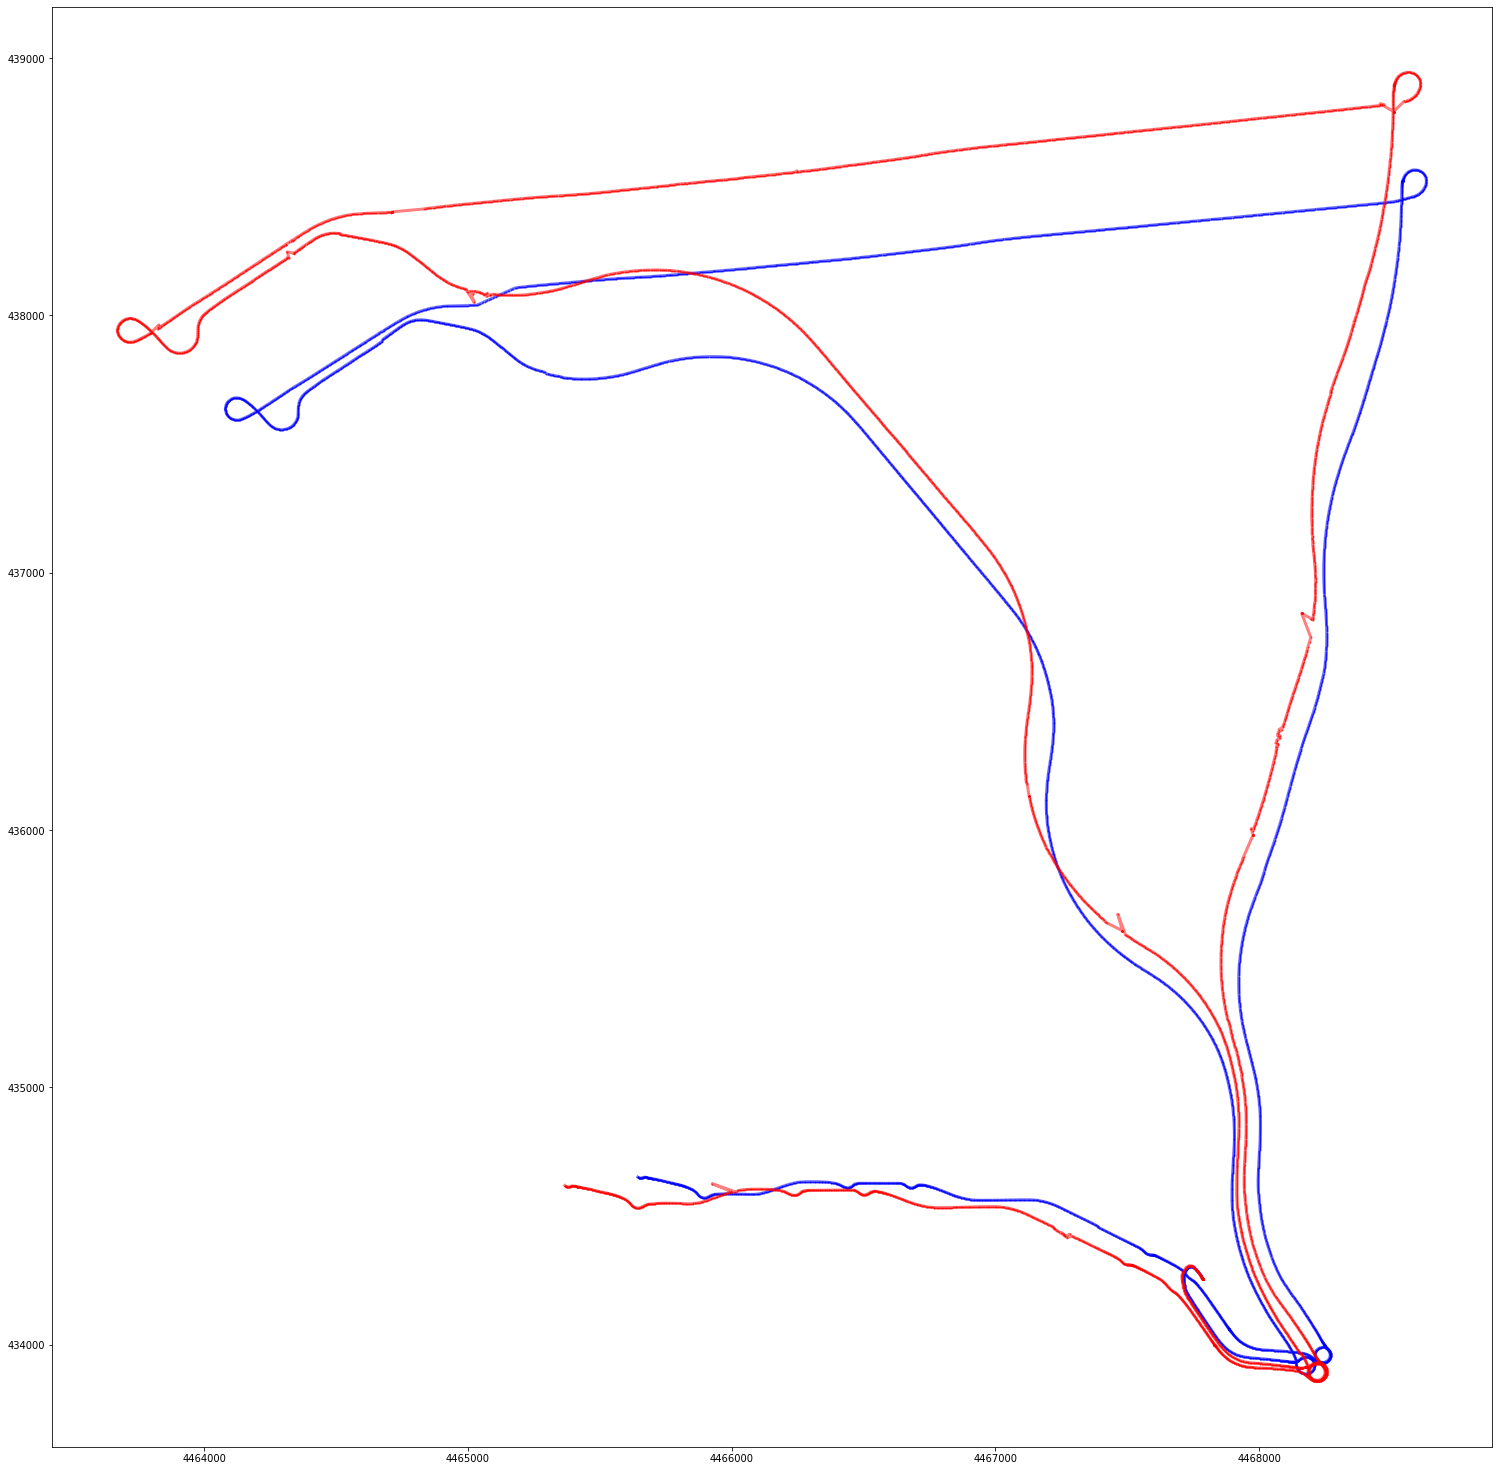

In [6]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame['North_Prediction(x)'],Prediction_DataFrame['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Prediction')
ax.plot(Pos_DataFrame['North'],Pos_DataFrame['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Data')

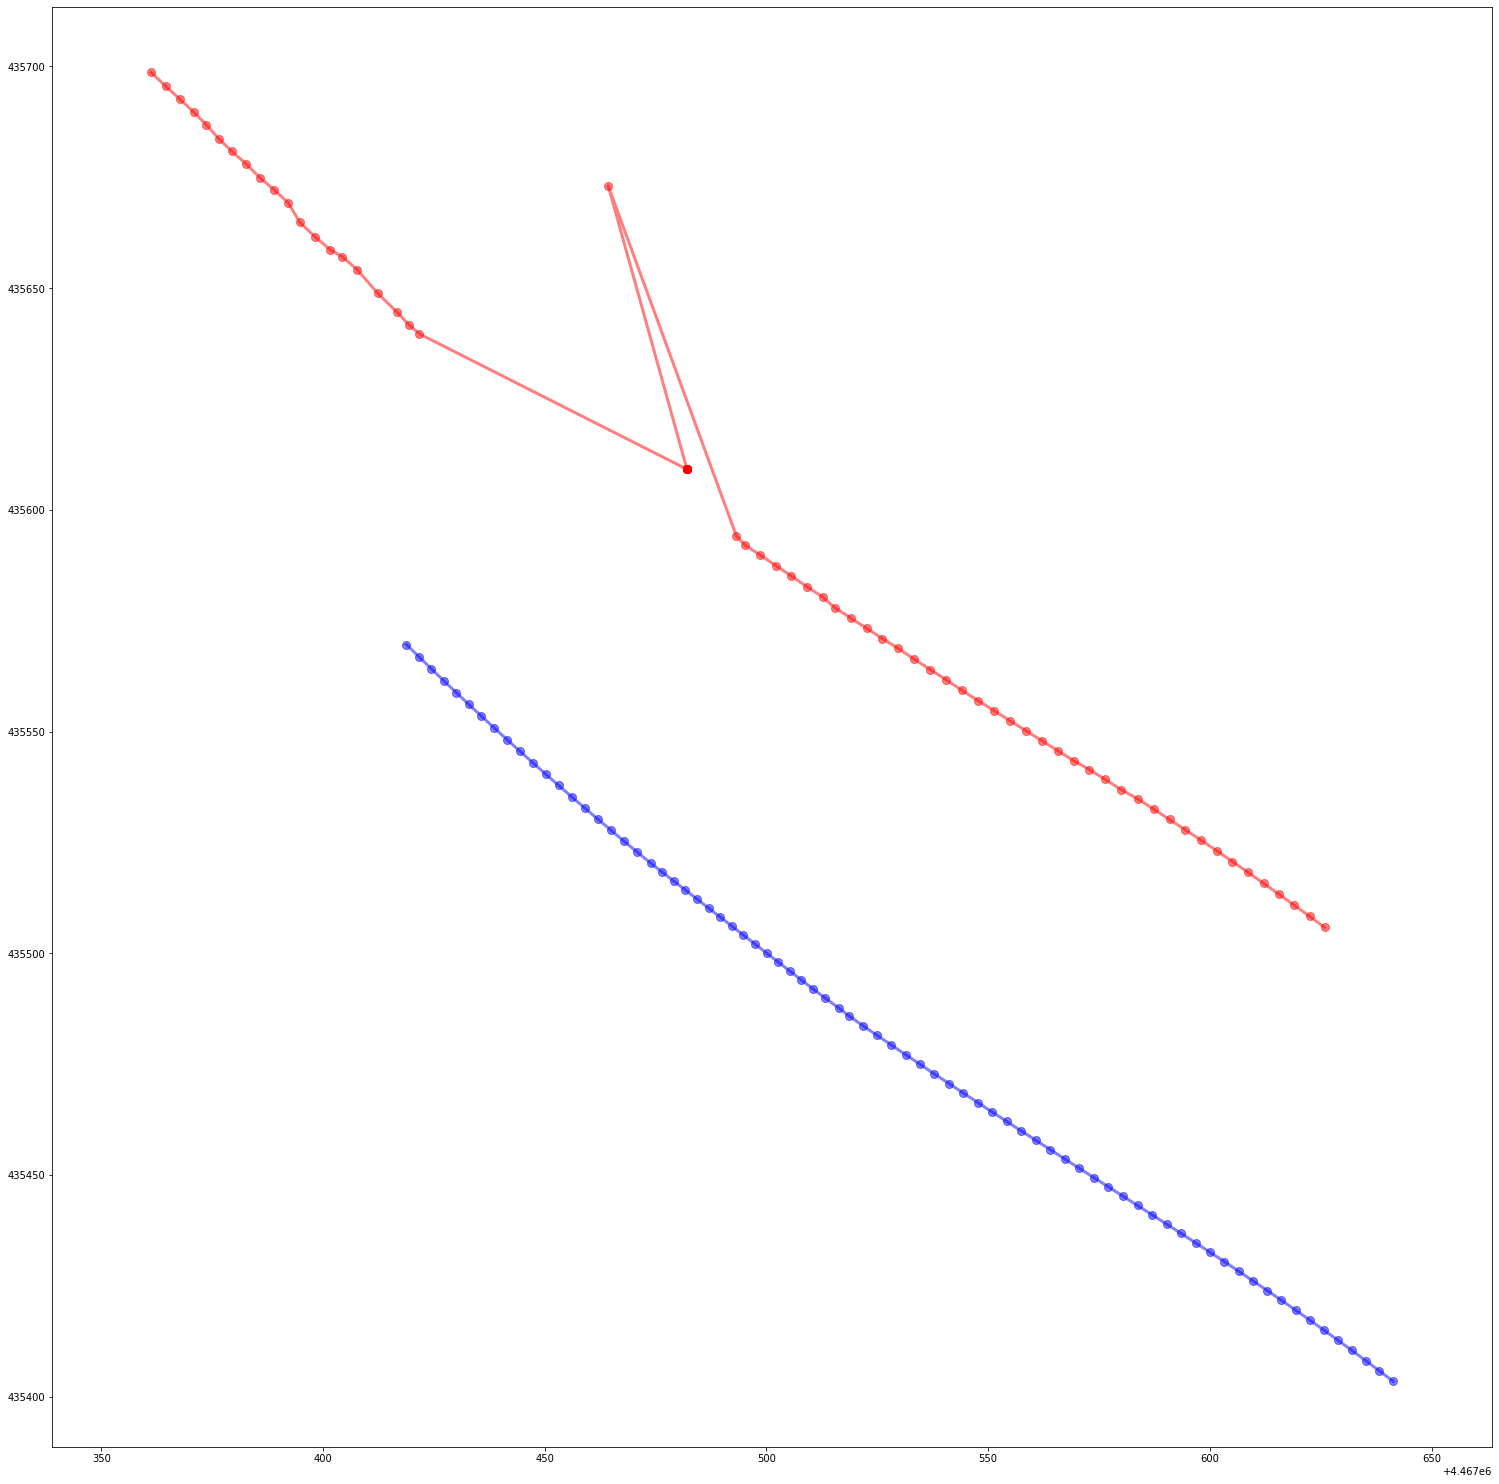

In [7]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[1475:1550]['North_Prediction(x)'],Prediction_DataFrame[1475:1550]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[1475:1550]['North'],Pos_DataFrame[1475:1550]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

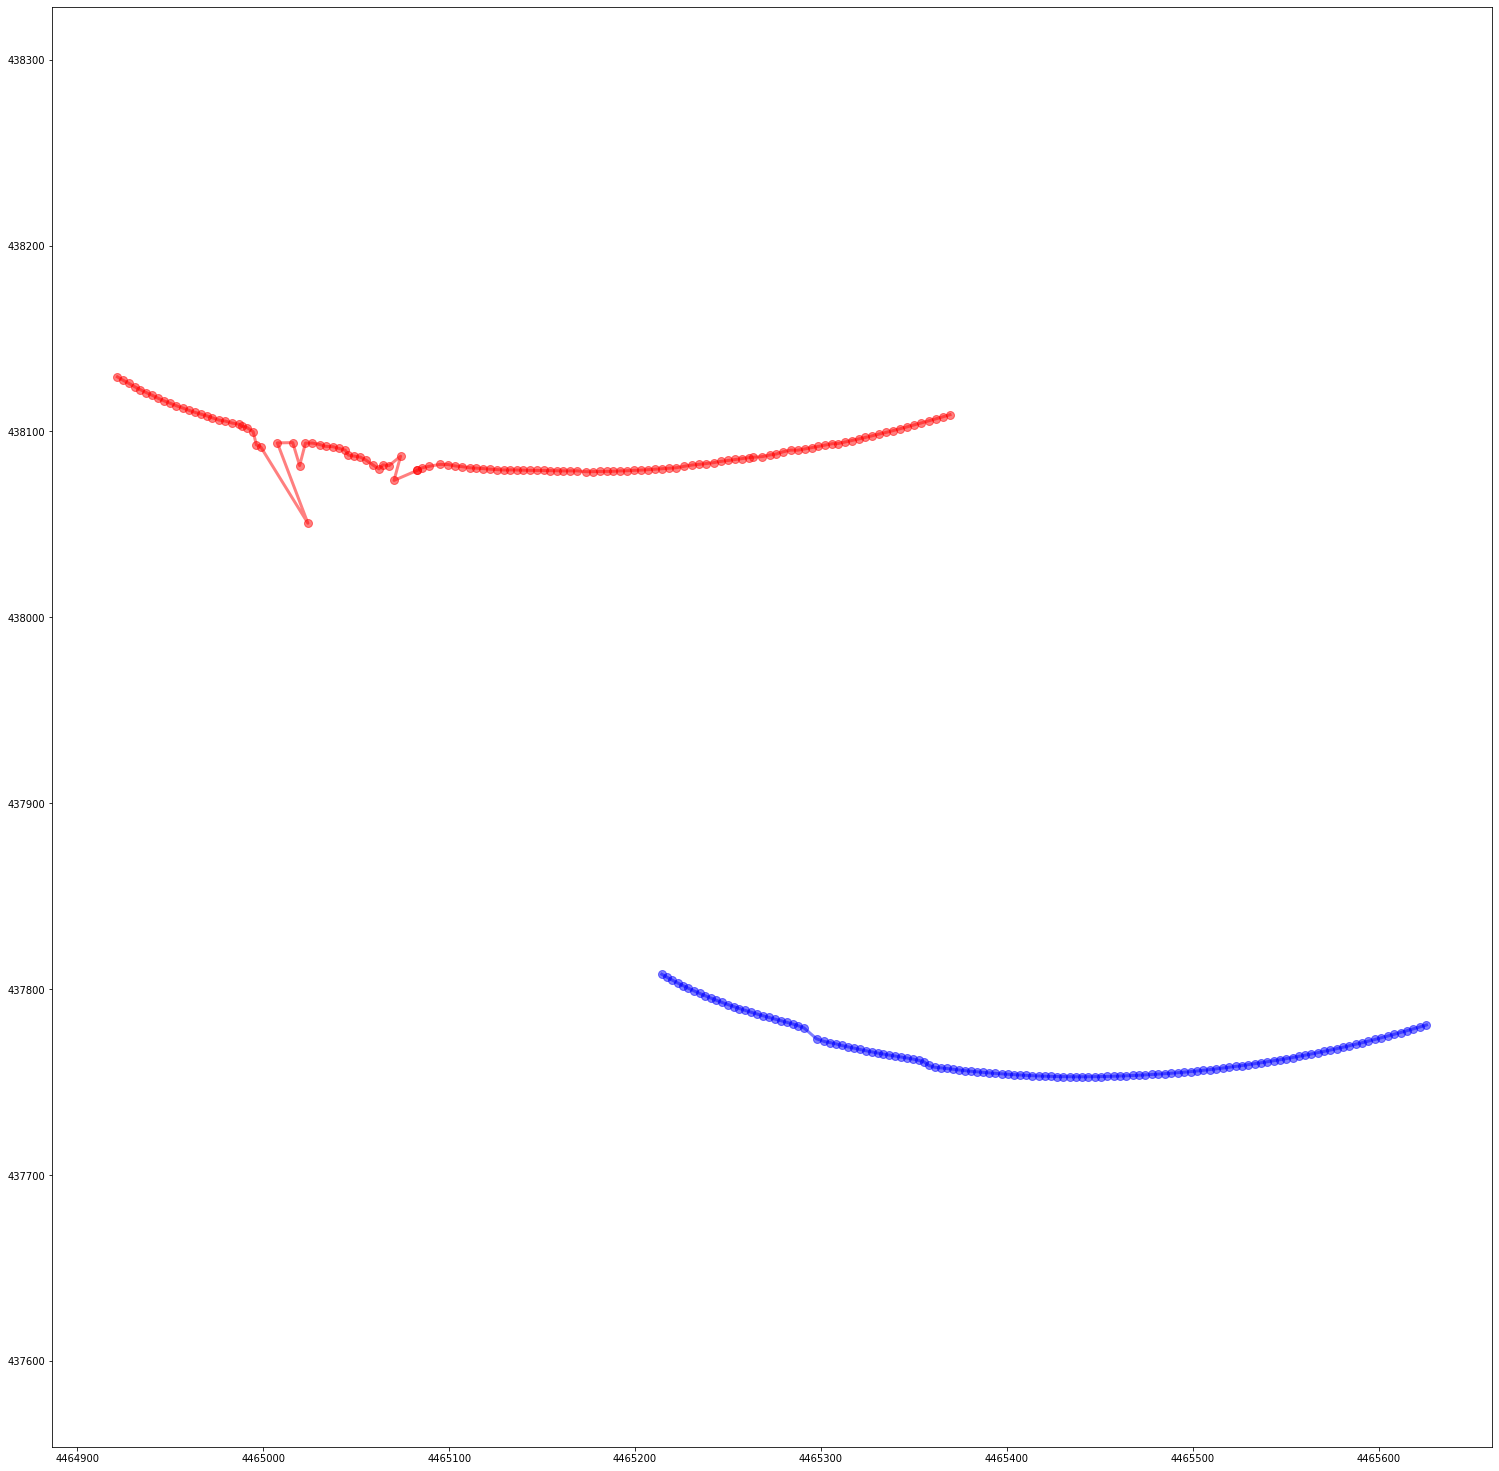

In [8]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[2420:2545]['North_Prediction(x)'],Prediction_DataFrame[2420:2545]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2420:2545]['North'],Pos_DataFrame[2420:2545]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

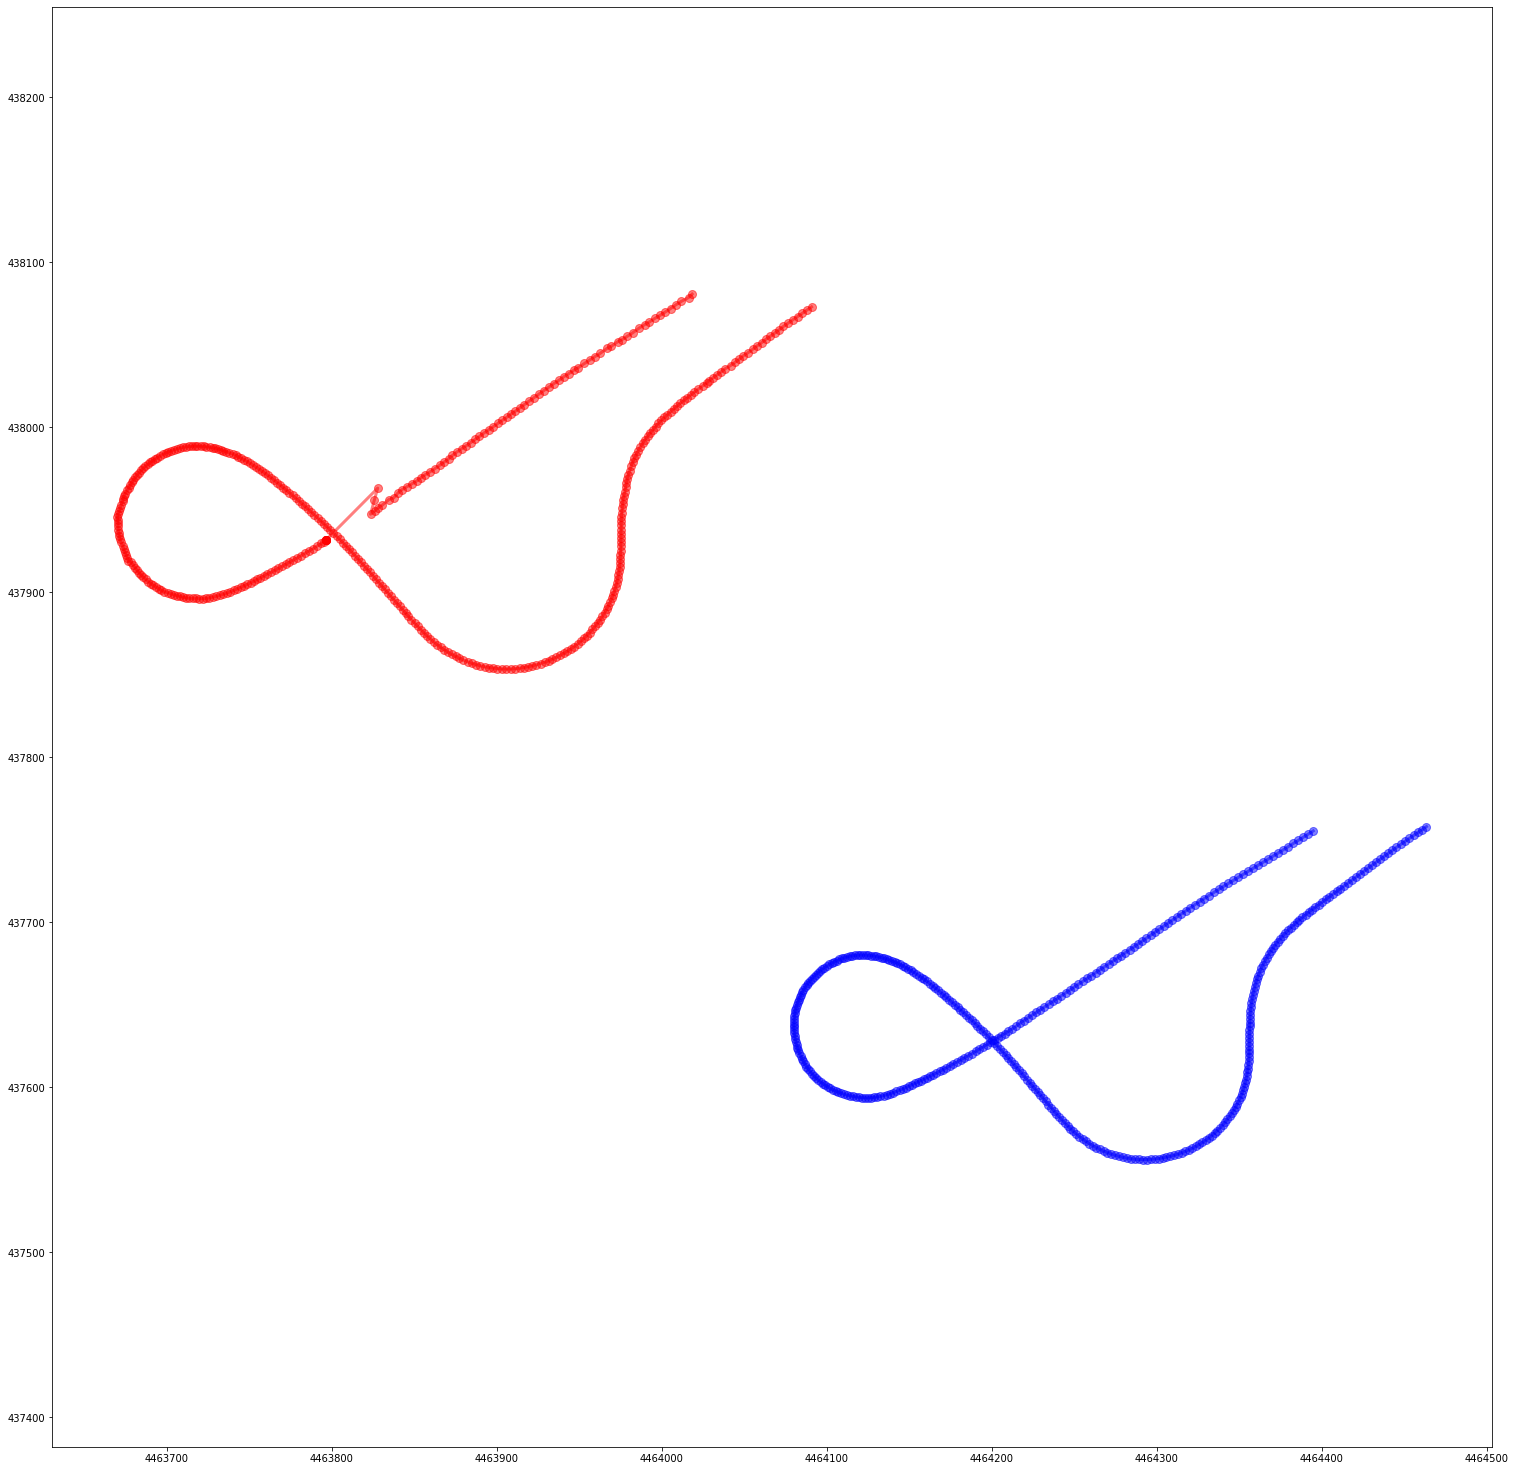

In [9]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[2850:3250]['North_Prediction(x)'],Prediction_DataFrame[2850:3250]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2850:3250]['North'],Pos_DataFrame[2850:3250]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

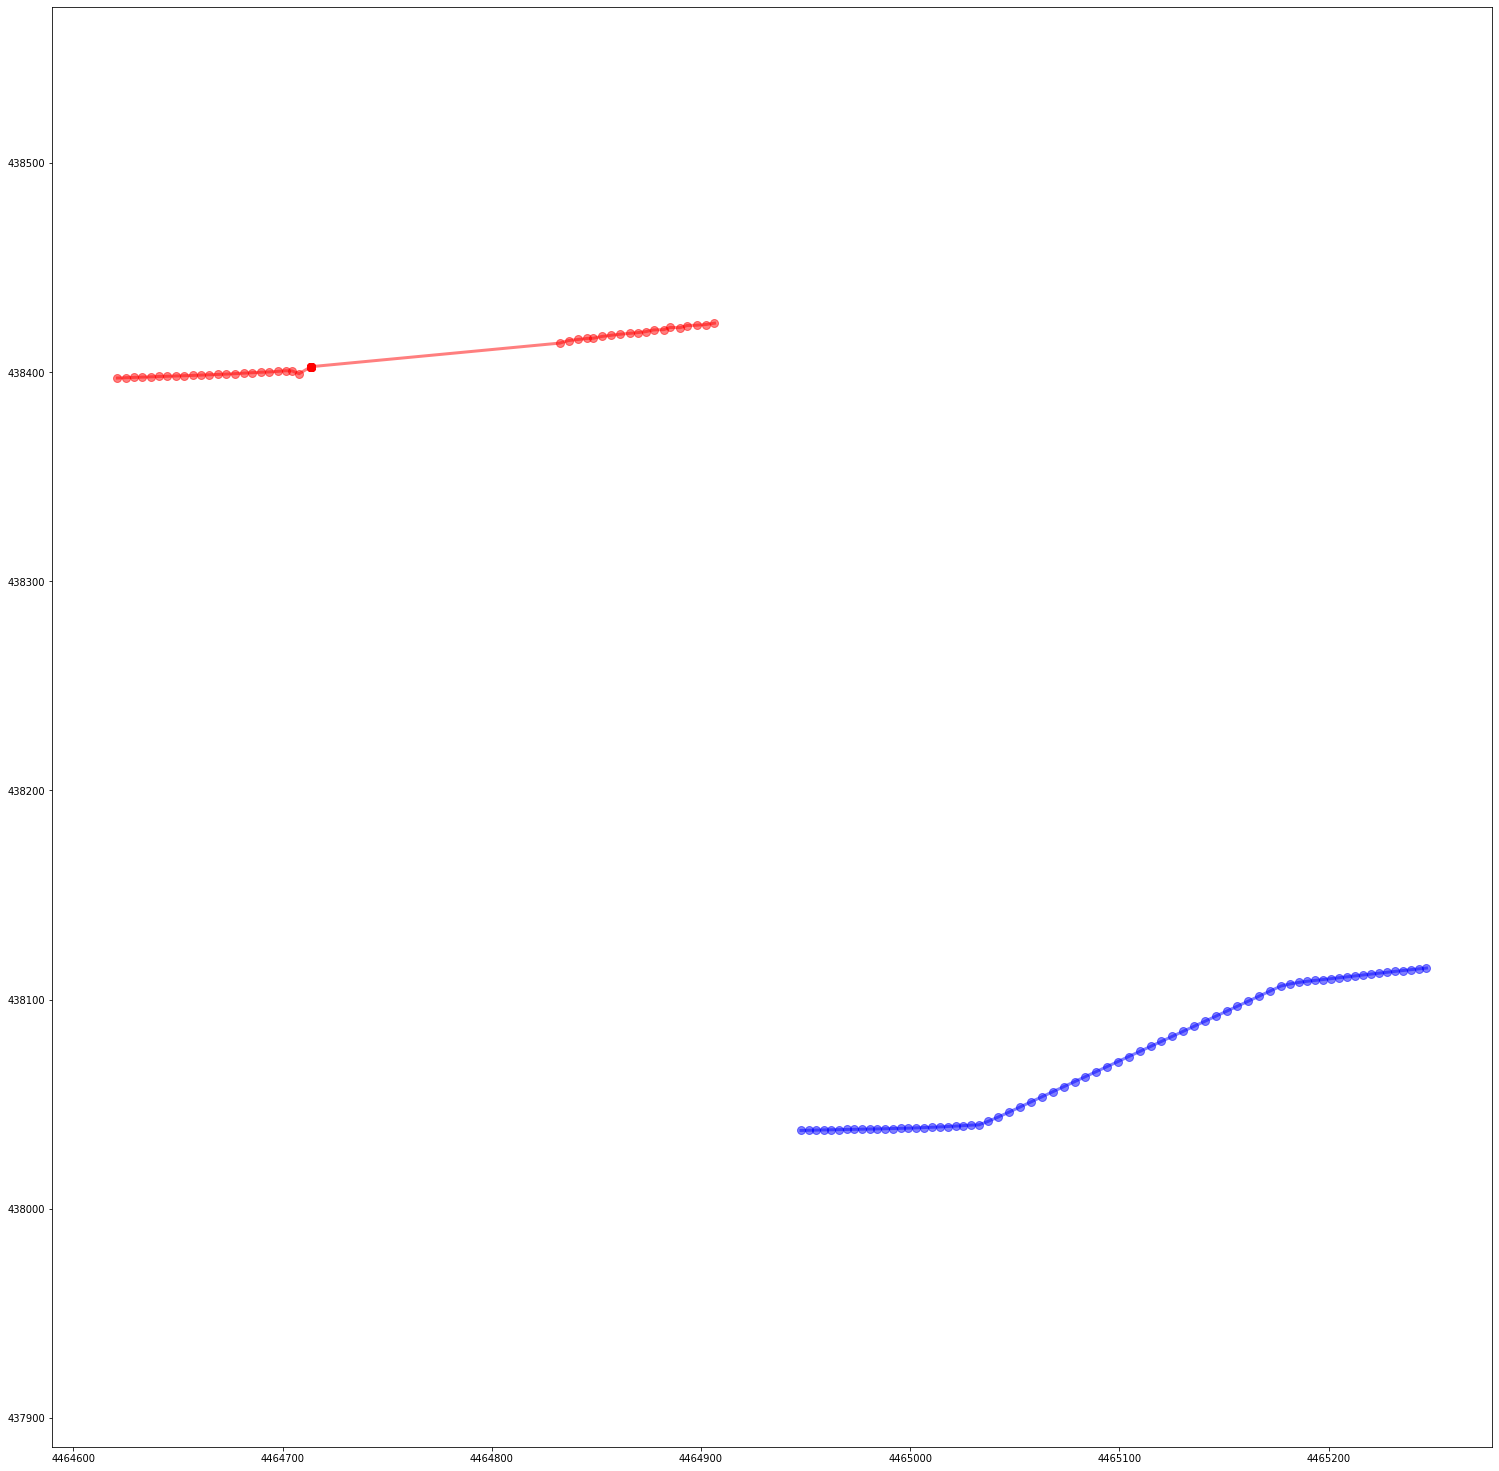

In [10]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[3420:3490]['North_Prediction(x)'],Prediction_DataFrame[3420:3490]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[3420:3490]['North'],Pos_DataFrame[3420:3490]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

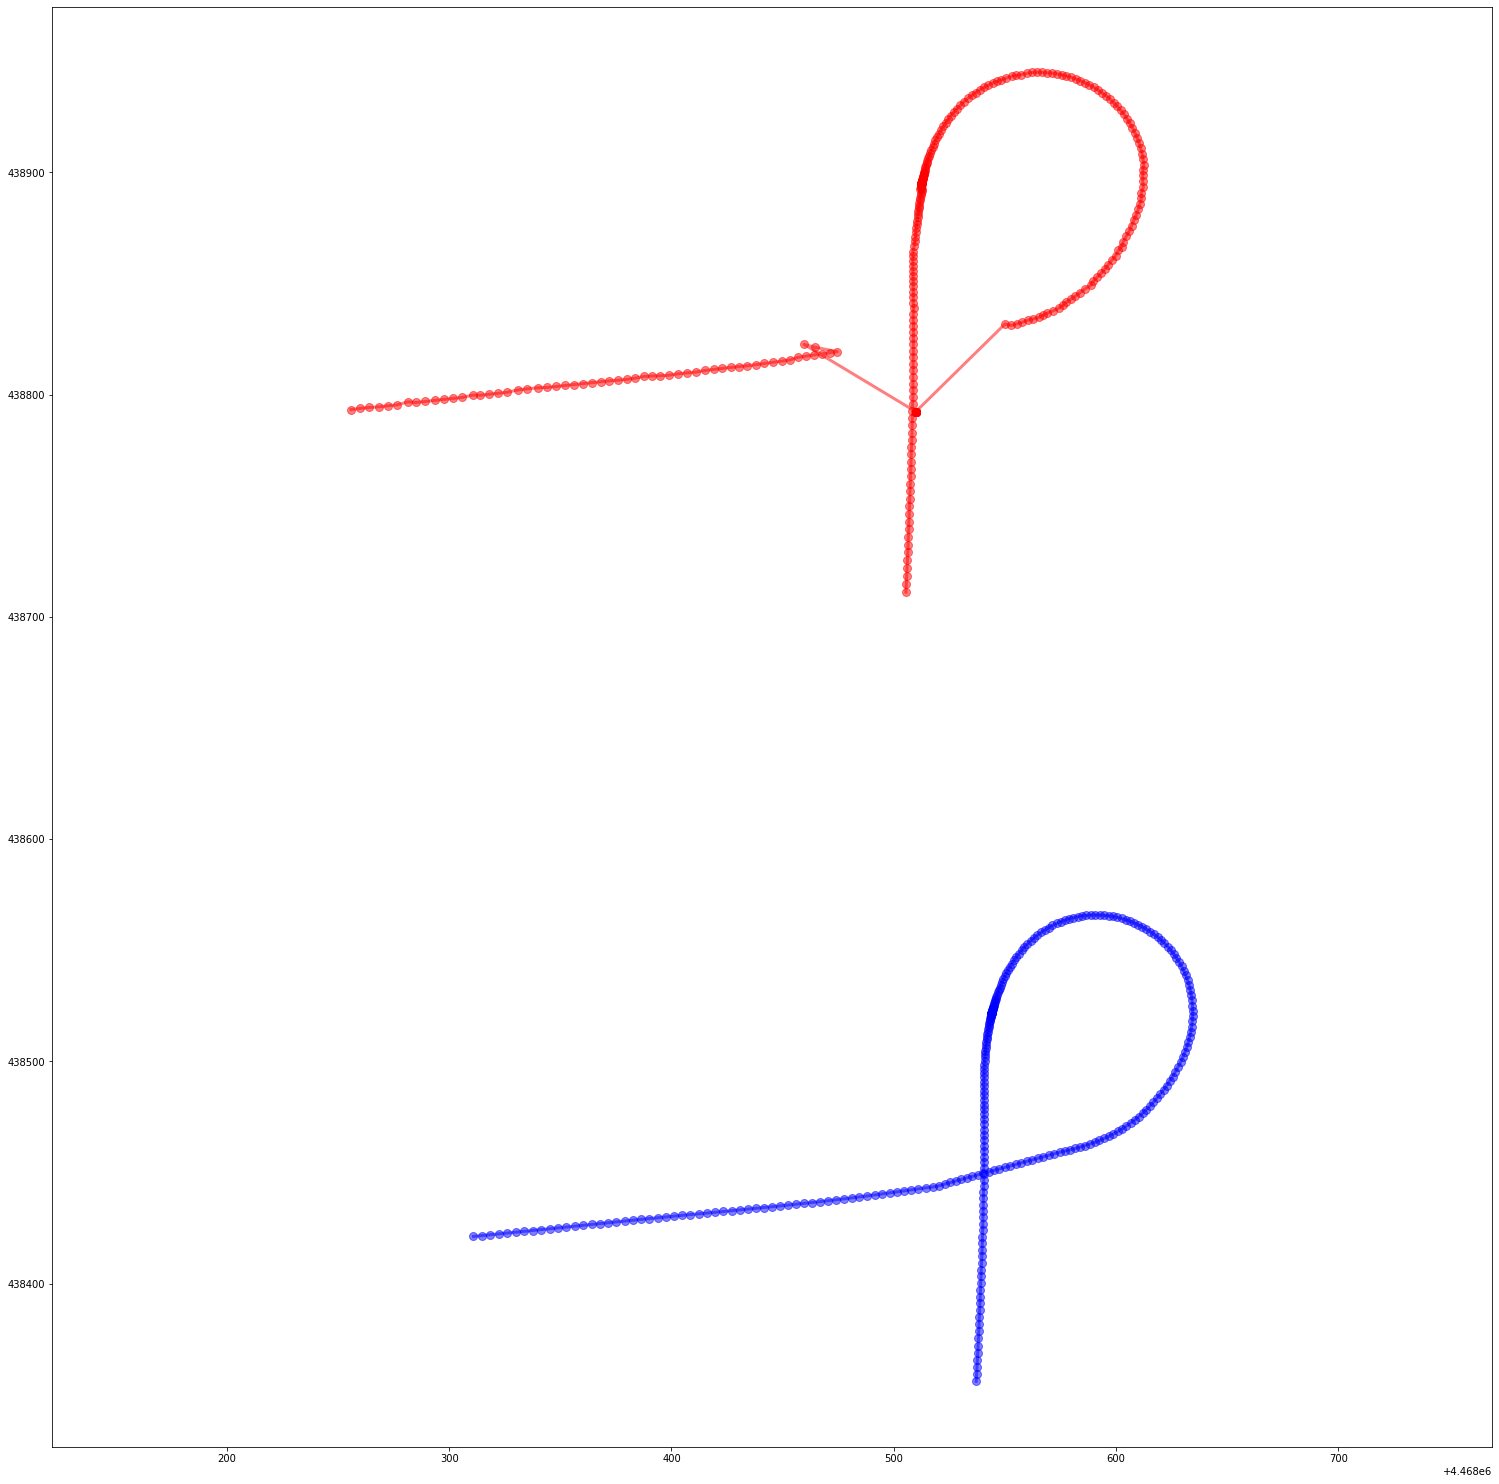

In [11]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[4300:4600]['North_Prediction(x)'],Prediction_DataFrame[4300:4600]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[4300:4600]['North'],Pos_DataFrame[4300:4600]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

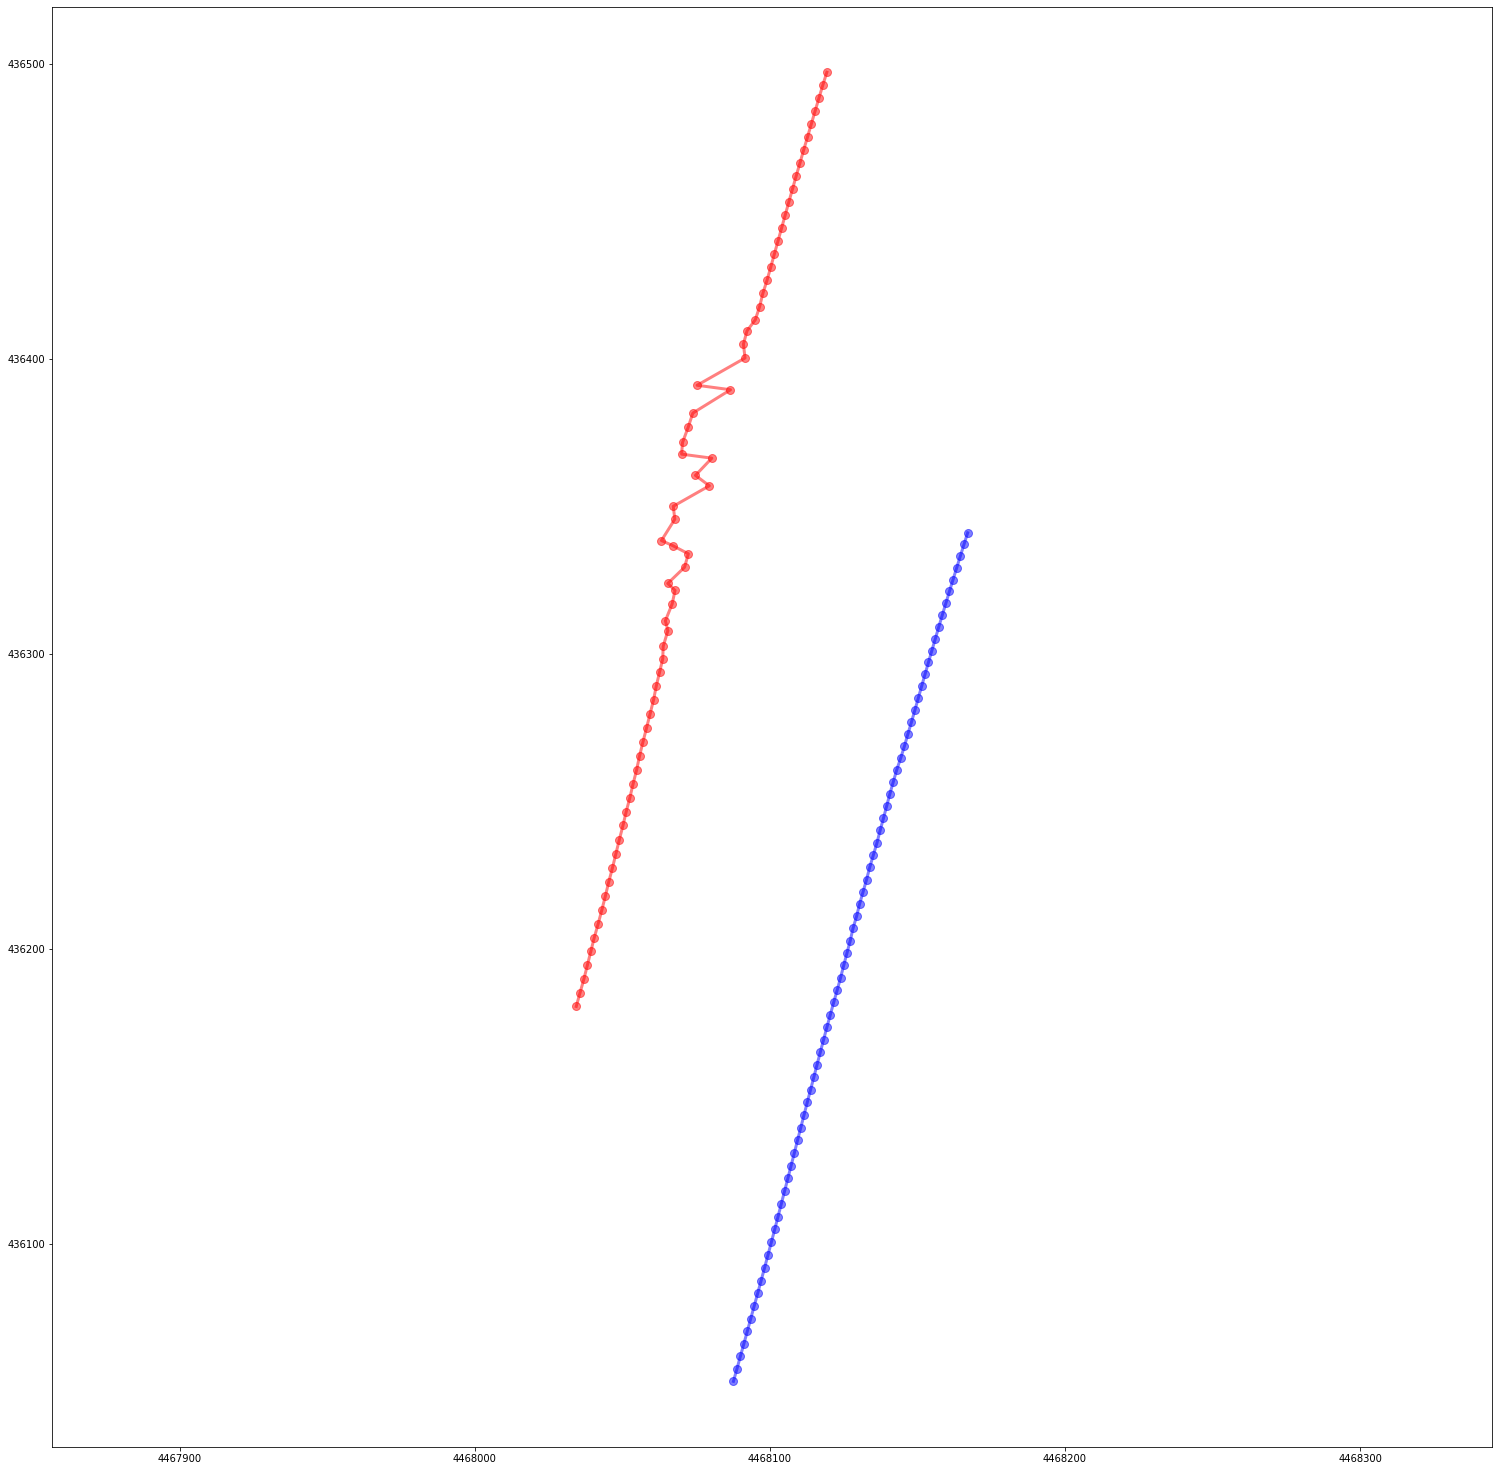

In [12]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[5115:5185]['North_Prediction(x)'],Prediction_DataFrame[5115:5185]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[5115:5185]['North'],Pos_DataFrame[5115:5185]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')